# Loading and saving the dataset

In [1]:
from datasets import load_dataset

# Load dataset from huggingface
dataset = load_dataset("Micol/musical-instruments-sound-dataset")

In [2]:
# Optional -> save to disk to prevent re-download
# dataset.save_to_disk("data/")

---------
# Dataset preprocessing

In [3]:
import torch
from torchaudio.transforms import MelSpectrogram, Resample
from torch.utils.data import DataLoader, Dataset as TorchDataset

In [4]:
# Define a custom PyTorch Dataset for pre-processing
class AudioDataset(TorchDataset):
    def __init__(self, dataset, target_sr=16000, fixed_duration=2):  # Fixed duration is now 2 seconds
        """
        Custom PyTorch Dataset for audio classification.
        
        Args:
            dataset: Hugging Face dataset containing 'audio' and 'label' columns.
            target_sr: Target sampling rate to resample all audio.
            fixed_duration: Fixed duration for all audio clips (in seconds).
        """
        self.dataset = dataset
        self.target_sr = target_sr
        self.num_samples = target_sr * fixed_duration

        # Mel Spectrogram transform
        self.mel_transform = MelSpectrogram(
            sample_rate=target_sr, 
            n_fft=1024, 
            hop_length=512, 
            n_mels=64
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load audio and label
        audio_array = self.dataset[idx]['audio']['array']
        sr = self.dataset[idx]['audio']['sampling_rate']
        label = self.dataset[idx]['label']
        
        # Convert to PyTorch tensor
        audio_tensor = torch.tensor(audio_array, dtype=torch.float32)
        # Resample if needed
        if sr != self.target_sr:
            resample_transform = Resample(orig_freq=sr, new_freq=self.target_sr)
            audio_tensor = resample_transform(audio_tensor)

        # Find the loudest part of the audio
        max_idx = torch.argmax(audio_tensor)  # Find index of the loudest part
        start_idx = max(0, max_idx - self.target_sr)  # One second to the left
        end_idx = min(audio_tensor.size(0), max_idx + self.target_sr)  # One second to the right

        audio_tensor = audio_tensor[start_idx:end_idx]

        # Pad or truncate to fixed length
        if audio_tensor.shape[0] > self.num_samples:
            audio_tensor = audio_tensor[:self.num_samples]  # Truncate
        else:
            padding = self.num_samples - audio_tensor.shape[0]
            audio_tensor = torch.nn.functional.pad(audio_tensor, (0, padding))  # Pad with zeros

        # Convert to Mel Spectrogram
        mel_spectrogram = self.mel_transform(audio_tensor)

        return mel_spectrogram, label

In [5]:
# Split dataset into train and test sets
train_dataset = AudioDataset(dataset['train'])
validation_dataset = AudioDataset(dataset['validation'])
test_dataset = AudioDataset(dataset['test'])

In [6]:
# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

----
# Model implementation

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [8]:
class EfficientNetAudioClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(EfficientNetAudioClassifier, self).__init__()
        
        # Load pretrained EfficientNet-B0
        self.efficientnet = models.efficientnet_b0(weights='DEFAULT' if pretrained else None)
        
        # Modify the first convolution layer to accept 1 channel input (grayscale) instead of 3 (RGB)
        self.efficientnet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        
        # Replace the classifier
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)

In [9]:
# Number of classes based on dataset
num_classes = len(dataset['train'].features['label'].names)

# Instantiate the model
model = EfficientNetAudioClassifier(num_classes=num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer, loss function and scheduler this time
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [10]:
from tqdm import tqdm

# train loop
def train(model, train_loader, validation_loader, criterion, optimizer, device, epochs, scheduler = None):
    best_accuracy = 0.0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for mel_spectrograms, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            mel_spectrograms = mel_spectrograms.unsqueeze(1).to(device)  # Add channel dimension
            labels = labels.to(device)

            # Forward pass
            outputs = model(mel_spectrograms)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for mel_spectrograms, labels in validation_loader:
                mel_spectrograms = mel_spectrograms.unsqueeze(1).to(device)
                labels = labels.to(device)

                outputs = model(mel_spectrograms)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(validation_loader)
        val_accuracy = correct / total

        # Step the scheduler if it exists
        if scheduler is not None:
            scheduler.step(avg_val_loss)

        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_state = model.state_dict()

        print(f"Epoch {epoch+1}: "
              f"Train Loss = {avg_train_loss:.4f}, "
              f"Train Accuracy = {train_accuracy:.4f}, "
              f"Val Loss = {avg_val_loss:.4f}, "
              f"Val Accuracy = {val_accuracy:.4f}")

    return best_model_state, best_accuracy

In [11]:
#train(model, train_loader, validation_loader, criterion, optimizer, device, epochs=50)
best_model_state, best_accuracy = train(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=50,
    scheduler=scheduler
)

Epoch 1/50: 100%|██████████| 66/66 [00:59<00:00,  1.10it/s]


Epoch 1: Train Loss = 0.8907, Train Accuracy = 0.5749, Val Loss = 0.8845, Val Accuracy = 0.5323


Epoch 2/50: 100%|██████████| 66/66 [00:56<00:00,  1.16it/s]


Epoch 2: Train Loss = 0.6942, Train Accuracy = 0.6415, Val Loss = 0.7035, Val Accuracy = 0.6692


Epoch 3/50: 100%|██████████| 66/66 [00:57<00:00,  1.15it/s]


Epoch 3: Train Loss = 0.6139, Train Accuracy = 0.6629, Val Loss = 0.6366, Val Accuracy = 0.6331


Epoch 4/50: 100%|██████████| 66/66 [00:56<00:00,  1.17it/s]


Epoch 4: Train Loss = 0.5455, Train Accuracy = 0.6790, Val Loss = 0.5901, Val Accuracy = 0.6749


Epoch 5/50: 100%|██████████| 66/66 [00:56<00:00,  1.18it/s]


Epoch 5: Train Loss = 0.5506, Train Accuracy = 0.7000, Val Loss = 0.6889, Val Accuracy = 0.6407


Epoch 6/50: 100%|██████████| 66/66 [00:56<00:00,  1.17it/s]


Epoch 6: Train Loss = 0.5067, Train Accuracy = 0.6995, Val Loss = 0.5863, Val Accuracy = 0.6920


Epoch 7/50: 100%|██████████| 66/66 [00:56<00:00,  1.17it/s]


Epoch 7: Train Loss = 0.4782, Train Accuracy = 0.7123, Val Loss = 0.5160, Val Accuracy = 0.6844


Epoch 8/50: 100%|██████████| 66/66 [00:56<00:00,  1.17it/s]


Epoch 8: Train Loss = 0.4658, Train Accuracy = 0.7175, Val Loss = 0.5075, Val Accuracy = 0.6844


Epoch 9/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 9: Train Loss = 0.4691, Train Accuracy = 0.7033, Val Loss = 0.5584, Val Accuracy = 0.6597


Epoch 10/50: 100%|██████████| 66/66 [00:55<00:00,  1.20it/s]


Epoch 10: Train Loss = 0.4300, Train Accuracy = 0.7109, Val Loss = 0.6052, Val Accuracy = 0.6559


Epoch 11/50: 100%|██████████| 66/66 [00:55<00:00,  1.20it/s]


Epoch 11: Train Loss = 0.4238, Train Accuracy = 0.7214, Val Loss = 0.4907, Val Accuracy = 0.6977


Epoch 12/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 12: Train Loss = 0.4177, Train Accuracy = 0.7218, Val Loss = 0.5072, Val Accuracy = 0.6901


Epoch 13/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 13: Train Loss = 0.4357, Train Accuracy = 0.7199, Val Loss = 0.5517, Val Accuracy = 0.6844


Epoch 14/50: 100%|██████████| 66/66 [00:54<00:00,  1.22it/s]


Epoch 14: Train Loss = 0.4316, Train Accuracy = 0.7209, Val Loss = 0.4911, Val Accuracy = 0.6958


Epoch 15/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 15: Train Loss = 0.3984, Train Accuracy = 0.7480, Val Loss = 0.5152, Val Accuracy = 0.7034


Epoch 16/50: 100%|██████████| 66/66 [00:55<00:00,  1.20it/s]


Epoch 16: Train Loss = 0.3881, Train Accuracy = 0.7332, Val Loss = 0.4768, Val Accuracy = 0.6730


Epoch 17/50: 100%|██████████| 66/66 [00:55<00:00,  1.18it/s]


Epoch 17: Train Loss = 0.3916, Train Accuracy = 0.7285, Val Loss = 0.4812, Val Accuracy = 0.6768


Epoch 18/50: 100%|██████████| 66/66 [00:55<00:00,  1.19it/s]


Epoch 18: Train Loss = 0.3889, Train Accuracy = 0.7304, Val Loss = 0.4805, Val Accuracy = 0.6616


Epoch 19/50: 100%|██████████| 66/66 [00:55<00:00,  1.20it/s]


Epoch 19: Train Loss = 0.3797, Train Accuracy = 0.7389, Val Loss = 0.4880, Val Accuracy = 0.6445


Epoch 20/50: 100%|██████████| 66/66 [00:54<00:00,  1.20it/s]


Epoch 20: Train Loss = 0.3858, Train Accuracy = 0.7413, Val Loss = 0.4887, Val Accuracy = 0.6521


Epoch 21/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 21: Train Loss = 0.3816, Train Accuracy = 0.7413, Val Loss = 0.4884, Val Accuracy = 0.6388


Epoch 22/50: 100%|██████████| 66/66 [00:54<00:00,  1.22it/s]


Epoch 22: Train Loss = 0.3781, Train Accuracy = 0.7394, Val Loss = 0.4797, Val Accuracy = 0.6388


Epoch 23/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 23: Train Loss = 0.3778, Train Accuracy = 0.7470, Val Loss = 0.4856, Val Accuracy = 0.6445


Epoch 24/50: 100%|██████████| 66/66 [00:54<00:00,  1.22it/s]


Epoch 24: Train Loss = 0.3989, Train Accuracy = 0.7394, Val Loss = 0.4831, Val Accuracy = 0.6350


Epoch 25/50: 100%|██████████| 66/66 [00:54<00:00,  1.20it/s]


Epoch 25: Train Loss = 0.3761, Train Accuracy = 0.7570, Val Loss = 0.4849, Val Accuracy = 0.6426


Epoch 26/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 26: Train Loss = 0.3822, Train Accuracy = 0.7394, Val Loss = 0.4841, Val Accuracy = 0.6464


Epoch 27/50: 100%|██████████| 66/66 [00:54<00:00,  1.22it/s]


Epoch 27: Train Loss = 0.3808, Train Accuracy = 0.7342, Val Loss = 0.4790, Val Accuracy = 0.6331


Epoch 28/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 28: Train Loss = 0.3777, Train Accuracy = 0.7494, Val Loss = 0.4830, Val Accuracy = 0.6369


Epoch 29/50: 100%|██████████| 66/66 [00:55<00:00,  1.20it/s]


Epoch 29: Train Loss = 0.3760, Train Accuracy = 0.7442, Val Loss = 0.4934, Val Accuracy = 0.6350


Epoch 30/50: 100%|██████████| 66/66 [00:56<00:00,  1.17it/s]


Epoch 30: Train Loss = 0.3781, Train Accuracy = 0.7470, Val Loss = 0.4901, Val Accuracy = 0.6426


Epoch 31/50: 100%|██████████| 66/66 [00:56<00:00,  1.17it/s]


Epoch 31: Train Loss = 0.3788, Train Accuracy = 0.7480, Val Loss = 0.4861, Val Accuracy = 0.6426


Epoch 32/50: 100%|██████████| 66/66 [00:56<00:00,  1.17it/s]


Epoch 32: Train Loss = 0.3774, Train Accuracy = 0.7532, Val Loss = 0.4778, Val Accuracy = 0.6426


Epoch 33/50: 100%|██████████| 66/66 [00:55<00:00,  1.18it/s]


Epoch 33: Train Loss = 0.3770, Train Accuracy = 0.7504, Val Loss = 0.4847, Val Accuracy = 0.6502


Epoch 34/50: 100%|██████████| 66/66 [00:55<00:00,  1.20it/s]


Epoch 34: Train Loss = 0.3779, Train Accuracy = 0.7366, Val Loss = 0.4803, Val Accuracy = 0.6293


Epoch 35/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 35: Train Loss = 0.3801, Train Accuracy = 0.7580, Val Loss = 0.4763, Val Accuracy = 0.6293


Epoch 36/50: 100%|██████████| 66/66 [00:54<00:00,  1.20it/s]


Epoch 36: Train Loss = 0.3796, Train Accuracy = 0.7475, Val Loss = 0.4828, Val Accuracy = 0.6369


Epoch 37/50: 100%|██████████| 66/66 [00:55<00:00,  1.18it/s]


Epoch 37: Train Loss = 0.3759, Train Accuracy = 0.7456, Val Loss = 0.4892, Val Accuracy = 0.6445


Epoch 38/50: 100%|██████████| 66/66 [00:55<00:00,  1.19it/s]


Epoch 38: Train Loss = 0.3782, Train Accuracy = 0.7432, Val Loss = 0.4782, Val Accuracy = 0.6426


Epoch 39/50: 100%|██████████| 66/66 [00:54<00:00,  1.20it/s]


Epoch 39: Train Loss = 0.3795, Train Accuracy = 0.7494, Val Loss = 0.4869, Val Accuracy = 0.6369


Epoch 40/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 40: Train Loss = 0.3770, Train Accuracy = 0.7418, Val Loss = 0.4824, Val Accuracy = 0.6445


Epoch 41/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 41: Train Loss = 0.3775, Train Accuracy = 0.7451, Val Loss = 0.4840, Val Accuracy = 0.6483


Epoch 42/50: 100%|██████████| 66/66 [00:54<00:00,  1.22it/s]


Epoch 42: Train Loss = 0.3739, Train Accuracy = 0.7494, Val Loss = 0.4833, Val Accuracy = 0.6540


Epoch 43/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 43: Train Loss = 0.3795, Train Accuracy = 0.7342, Val Loss = 0.4774, Val Accuracy = 0.6483


Epoch 44/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 44: Train Loss = 0.3797, Train Accuracy = 0.7404, Val Loss = 0.4818, Val Accuracy = 0.6407


Epoch 45/50: 100%|██████████| 66/66 [00:55<00:00,  1.20it/s]


Epoch 45: Train Loss = 0.3787, Train Accuracy = 0.7494, Val Loss = 0.4816, Val Accuracy = 0.6331


Epoch 46/50: 100%|██████████| 66/66 [00:55<00:00,  1.18it/s]


Epoch 46: Train Loss = 0.3895, Train Accuracy = 0.7356, Val Loss = 0.4826, Val Accuracy = 0.6369


Epoch 47/50: 100%|██████████| 66/66 [00:55<00:00,  1.19it/s]


Epoch 47: Train Loss = 0.3754, Train Accuracy = 0.7442, Val Loss = 0.4764, Val Accuracy = 0.6293


Epoch 48/50: 100%|██████████| 66/66 [00:54<00:00,  1.20it/s]


Epoch 48: Train Loss = 0.3799, Train Accuracy = 0.7389, Val Loss = 0.4836, Val Accuracy = 0.6445


Epoch 49/50: 100%|██████████| 66/66 [00:53<00:00,  1.22it/s]


Epoch 49: Train Loss = 0.3819, Train Accuracy = 0.7499, Val Loss = 0.4841, Val Accuracy = 0.6407


Epoch 50/50: 100%|██████████| 66/66 [00:54<00:00,  1.22it/s]


Epoch 50: Train Loss = 0.3765, Train Accuracy = 0.7399, Val Loss = 0.4739, Val Accuracy = 0.6369


-----
# Evaluate

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Test Accuracy: 0.5375
Confusion Matrix:


<Figure size 1000x700 with 0 Axes>

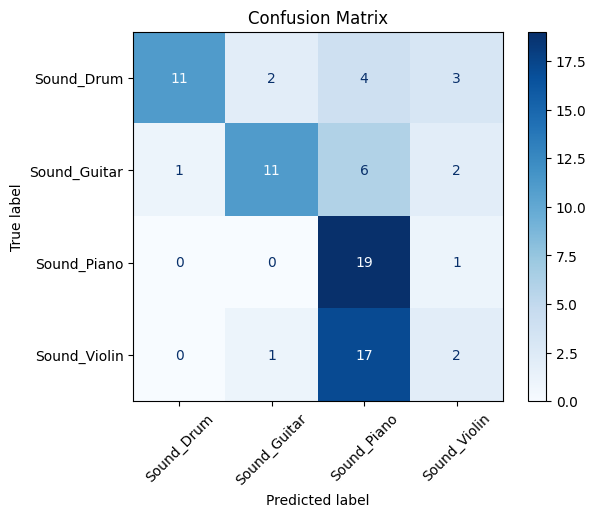

In [13]:
def evaluate(model, test_loader, device, class_names):
    model.eval()
    correct = 0
    total = 0
    
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for mel_spectrograms, labels in test_loader:
            mel_spectrograms, labels = mel_spectrograms.unsqueeze(1).to(device), labels.to(device)

            outputs = model(mel_spectrograms)
            _, predicted = torch.max(outputs, 1)

            # Track overall accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for the confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    print("Confusion Matrix:")
    plt.figure(figsize=(10, 7))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()

# Evaluate on test set
evaluate(model, test_loader, device, dataset['train'].features['label'].names)

In [14]:
torch.save(model, 'third_idea.pth')